In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from scipy import signal

In [2]:
def create_filled_lables(ft_df, eeg_df):
    """
    Fill feel trace missing values so that we have a value for every ms.
    We do this by repeating the last value until there is a change.
    """
    ft_arr = np.ones_like(eeg_df[:,:2]) * -1 # fill array with -1 to indicate values to fill
    ft_arr[:,0] = eeg_df[:,0] # fill time values in
    ft_arr_timestamps = ft_df[:,0] * 1000 # convert timestamps to indicies
    index_arr = (ft_arr_timestamps - ft_arr_timestamps[0]).astype(int) # actual convertion here, we remove offset
    
    ft_arr[index_arr,1] =  ft_df[:,1] # fill the known values in
    
    not_missing_mask = ft_arr[:,1] != -1 # non -1 values
    non_missing_index = np.where(not_missing_mask, np.arange(len(ft_arr[:,1])), -1) # obtain index of non missing values
    existing_val = np.maximum.accumulate(non_missing_index) # find max value index which corresponds to the first non -1 value in each interval
    
    ft_arr[not_missing_mask == False, 1] = ft_arr[existing_val[not_missing_mask == False], 1]
    
    return np.hstack((ft_arr, eeg_df[:,1:]))

In [3]:
def save_labeld_dataset(eeg_ft_dir = 'EEG_FT_DATA'):
    """
    Save the dataset generated by filling in the missing feel trace values to disk.
    We call this new dataset "aligned"
    """
    subject_data_files = glob.glob(os.path.join(eeg_ft_dir, '*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    # group the eeg and ft into pairs
    subject_data_pairs = [(subject_data_files[i], subject_data_files[i+1]) for i in range(0, len(subject_data_files) - 1, 2)]
    all_eeg_ft_names = [(x[0],x[1]) for x in subject_data_pairs]
    
    column_headers = ['t', 'stress'] + [f'channel_{i}' for i in range(64)]

    index = 0
    for x in all_eeg_ft_names:
        tmp_read_ft = pd.read_csv(x[1]).values
        tmp_read_eeg = pd.read_csv(x[0]).values
        
        input_label_pair = create_filled_lables(tmp_read_ft, tmp_read_eeg)
        
        df = pd.DataFrame(data=input_label_pair, columns=column_headers)
        
        df.to_csv(os.path.join('ALIGNED_DATA', f'EEG_FT_ALIGNED_{index}.csv'), index=False)
        
        del tmp_read_ft
        del tmp_read_eeg
        del input_label_pair
        
        index += 1

In [4]:
def load_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=4):
    """
    Deprecated
    """
    subject_data_files = glob.glob(os.path.join(eeg_ft_dir, '*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    # group data
    all_eeg_ft_names = subject_data_files
    
    dataset = []
    unfiltered = []
    sos = signal.butter(10, cutoff_lf, 'lp', fs=1000, output='sos')
    for x in all_eeg_ft_names[0:0+1]:
        input_label_pair = pd.read_csv(x).values
        input_label_pair_unfiltered = input_label_pair.copy()
        
        input_label_pair[:,2:] = signal.sosfiltfilt(sos, input_label_pair[:,2:], axis=0)
        
        n_chunks = len(input_label_pair)/split_size
        
        split_data = np.array_split(input_label_pair, n_chunks).copy()
        split_data_unfiltered = np.array_split(input_label_pair_unfiltered, n_chunks).copy()
        
        del input_label_pair_unfiltered
        del input_label_pair
        
        for x_split, y_split in zip(split_data, split_data_unfiltered):
                if len(x_split) >= split_size:
                    dataset.append(x_split[:split_size].copy())
                    unfiltered.append(y_split[:split_size].copy())
                    
    return dataset, unfiltered


def split_filtered_and_raw(filtered_data : list, raw_data : list, random_seed=128) -> list:
    
    autoencoder_split, classifier_split = train_test_split(filtered_data, test_size=0.7, random_state=random_seed, shuffle=True)
    autoencoder_split_raw, classifier_split_raw = train_test_split(raw_data, test_size=0.7, random_state=random_seed, shuffle=True)
    
    # split data into train and test
    autoencoder_train, autoencoder_test = train_test_split(np.array(autoencoder_split), test_size=0.2, random_state=random_seed, shuffle=True)
    autoencoder_train_raw, autoencoder_test_raw = train_test_split(np.array(autoencoder_split_raw), test_size=0.2, random_state=random_seed, shuffle=True)
    
    classifier_train, classifier_test = train_test_split(np.array(classifier_split), test_size=0.2, random_state=random_seed, shuffle=True)
    classifier_train_raw, classifier_test_raw = train_test_split(np.array(classifier_split_raw), test_size=0.2, random_state=random_seed, shuffle=True)

    
    # further split train into validation and train
    autoencoder_train, autoencoder_val = train_test_split(autoencoder_train, test_size=0.2, random_state=random_seed, shuffle=True)
    autoencoder_train_raw, autoencoder_val_raw = train_test_split(autoencoder_train_raw, test_size=0.2, random_state=random_seed, shuffle=True)
    
    classifier_train, classifier_val = train_test_split(classifier_train, test_size=0.2, random_state=random_seed, shuffle=True)
    classifier_train_raw, classifier_val_raw = train_test_split(classifier_train_raw, test_size=0.2, random_state=random_seed, shuffle=True)
    
    
    split_dataset = [autoencoder_train, autoencoder_val, autoencoder_test, autoencoder_train_raw, autoencoder_val_raw, autoencoder_test_raw,
                     classifier_train, classifier_val, classifier_test, classifier_train_raw, classifier_val_raw, classifier_test_raw]
    return split_dataset
    

def load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=4, random_seed=128, num_subjects = 5, subject_choice_seed=128):
    subject_data_files = glob.glob(os.path.join(eeg_ft_dir, '*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    # group data, pick num_subjects randomly
    np.random.seed(subject_choice_seed)
    all_eeg_ft_names = np.random.choice(subject_data_files, size=num_subjects, replace=False)
    print(f"Chosen subjects: {all_eeg_ft_names}")
    
    sos = signal.butter(10, cutoff_lf, 'lp', fs=1000, output='sos') # low pass filter
    
    
    full_dataset = []
    for x in all_eeg_ft_names:        
        dataset = []
        unfiltered = []
        
        input_label_pair = pd.read_csv(x).values
        input_label_pair_unfiltered = input_label_pair.copy()
        
        input_label_pair[:,2:] = signal.sosfiltfilt(sos, input_label_pair[:,2:], axis=0)
        
        n_chunks = len(input_label_pair)/split_size
        
        split_data = np.array_split(input_label_pair, n_chunks).copy()
        split_data_unfiltered = np.array_split(input_label_pair_unfiltered, n_chunks).copy()
        
        del input_label_pair_unfiltered
        del input_label_pair
        
        for x_split, y_split in zip(split_data, split_data_unfiltered):
                if len(x_split) >= split_size:
                    dataset.append(x_split[:split_size].copy())
                    unfiltered.append(y_split[:split_size].copy())
                    
        split_dataset = split_filtered_and_raw(dataset, unfiltered, random_seed) # split data into train, validation and test sets
        
        full_dataset.append(split_dataset)
    return convert_loaded_dataset(full_dataset)

def convert_loaded_dataset(full_dataset):
    '''
    convert the full list into individual numpy arrays
    '''
    return [np.vstack([x[i] for x in full_dataset]) for i in range(12) ]

In [11]:
from sklearn.model_selection import train_test_split
dataset = load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=4, random_seed=128, num_subjects = 5)

classifier_train, classifier_val, classifier_test = dataset[6:9]
autoencoder_train, autoencoder_val, autoencoder_test = dataset[:3]

Chosen subjects: ['ALIGNED_DATA/EEG_FT_ALIGNED_9.csv' 'ALIGNED_DATA/EEG_FT_ALIGNED_8.csv'
 'ALIGNED_DATA/EEG_FT_ALIGNED_6.csv' 'ALIGNED_DATA/EEG_FT_ALIGNED_0.csv'
 'ALIGNED_DATA/EEG_FT_ALIGNED_11.csv']


18813


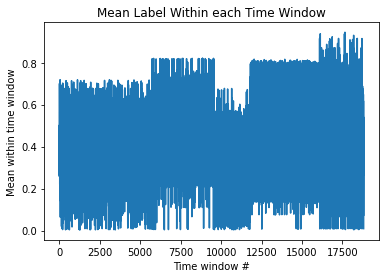

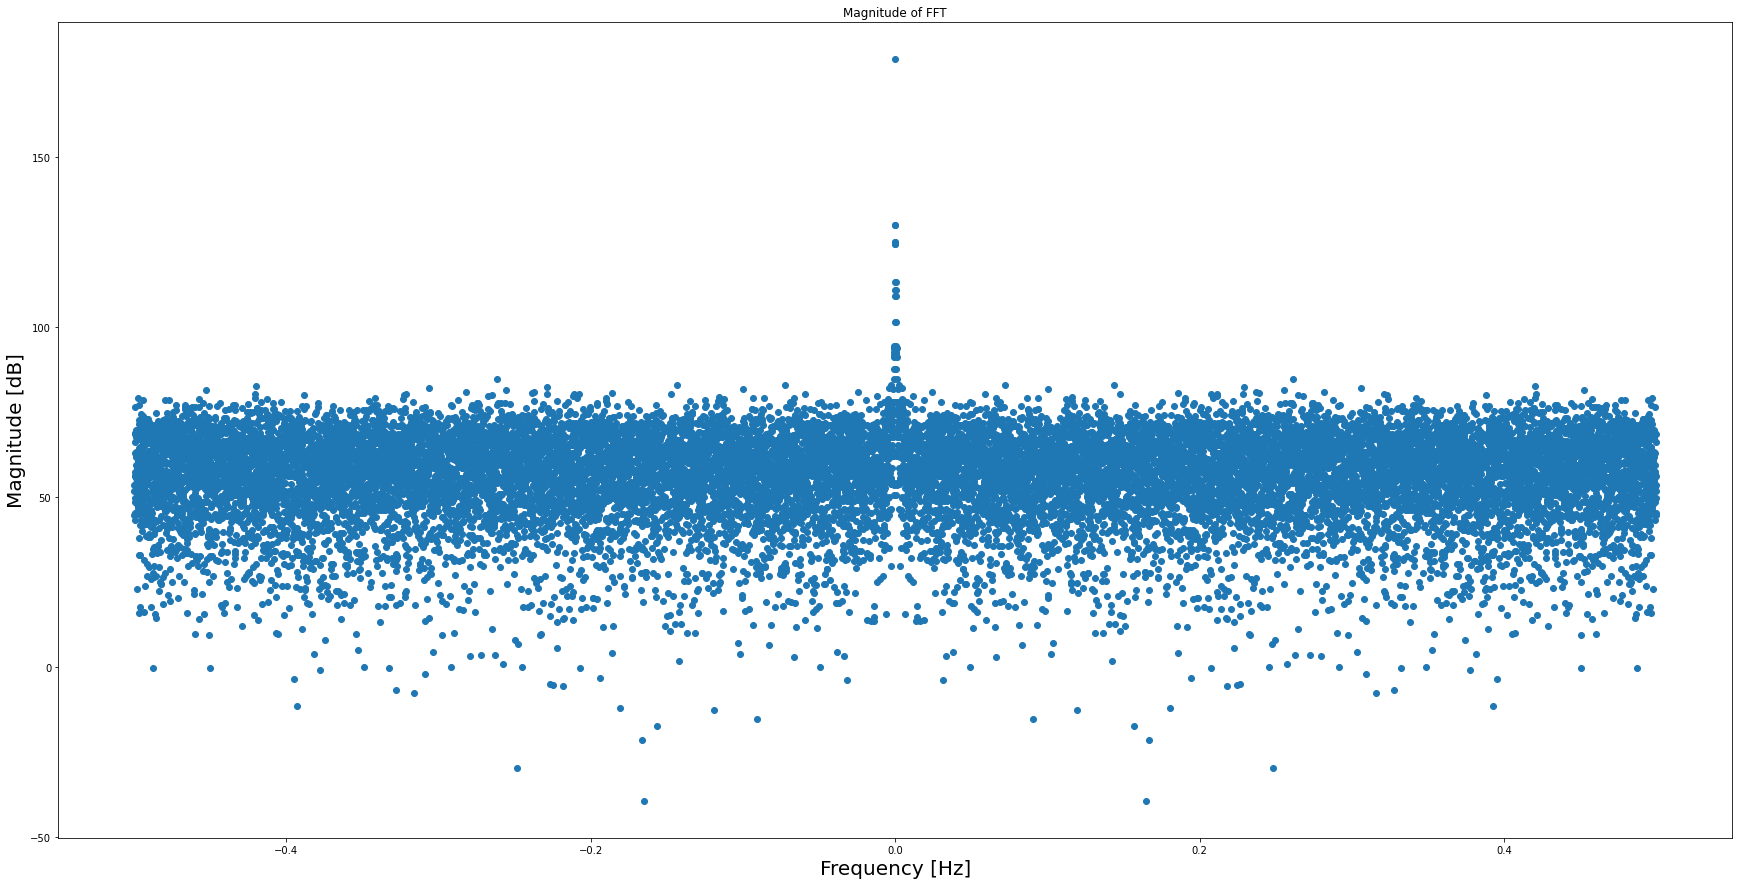

In [12]:
data = classifier_train[:, :, 1].mean(axis=-1)
freq = np.fft.fftfreq(data.size)
print(data.size)
plt.plot(np.arange(data.shape[0]), data)
plt.xlabel("Time window #")
plt.ylabel("Mean within time window")
plt.title("Mean Label Within each Time Window")
fig, axs = plt.subplots(figsize=(30,15))
fft_window = np.abs(np.fft.fft(data))


axs.scatter( freq, 20*np.log(fft_window))

axs.set_xlabel('Frequency [Hz]', fontsize=20);
axs.set_ylabel('Magnitude [dB]', fontsize=20)
axs.set_title(f"Magnitude of FFT")
plt.show()

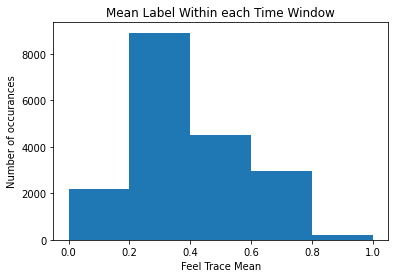

In [13]:
plt.hist(data, bins=5, range=(0,1))
plt.xlabel("Feel Trace Mean")
plt.ylabel("Number of occurances")
plt.title("Mean Label Within each Time Window")
plt.show()

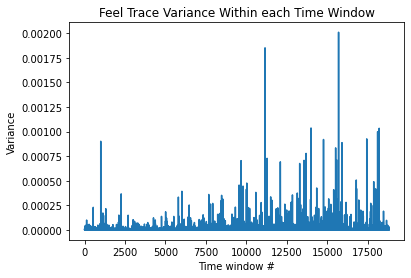

In [14]:
plt.plot(classifier_train[:, :, 1].var(axis=-1))
plt.xlabel("Time window #")
plt.ylabel("Variance")
plt.title("Feel Trace Variance Within each Time Window")
plt.show()

In [15]:
print(classifier_train[:, :, 1].var(axis=-1).argmax())

15701


In [20]:
def encode_classifier_data(encoder_path="models/ae_model_100ms_subject_0_4Hz_8_features.pth", classifier_data_in=classifier_test, encoding=8):
    ae_model = autoencoder(encoding)
    ae_model.load_state_dict(torch.load(encoder_path))
    ae_model.eval()
    with torch.no_grad():
        prev_shape = classifier_data_in.shape
        x = torch.from_numpy(classifier_data_in[:,:,2:]).float().reshape(-1,1,64) # eeg channels
        x_encoded = ae_model.encode(x).reshape(prev_shape[0], prev_shape[1], encoding).numpy()

        tmp_arr = np.zeros((prev_shape[0], prev_shape[1], 2 + encoding))
        tmp_arr[:, :, :2] = classifier_data_in[:,:,:2].copy() # copy timestamps and feel trace
        tmp_arr[:,:, 2:] = x_encoded # copy encoded eeg
        return tmp_arr

In [ ]:
classifier_test = encode_classifier_data(classifier_data_in=classifier_test)
classifier_val = encode_classifier_data(classifier_data_in=classifier_val)
classifier_train = encode_classifier_data(classifier_data_in=classifier_train)

In [16]:
classifier_test.shape

(5884, 100, 66)

In [13]:
def stress_2_label(mean_stress, n_labels=5):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.digitize(mean_stress * n_labels, np.arange(n_labels)) - 1

class classifier_dataset(torch.utils.data.Dataset):
    def __init__(self, X, n_labels=5):
        'Initialization'
        self.x = X
        self.n_labels = n_labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index,:,2:]).float() # eeg channels
        y = np.array(stress_2_label(self.x[index, :, 1].mean(axis=-1), n_labels=5)).astype(int)
        y = torch.from_numpy(y) # feel trace labels int value [0,n_labels]
        return x, y